# **Experiment Notebook**



---
## Setup Environment

In [1]:
# DO NOT MODIFY THE CODE IN THIS CELL
!pip install -q utstd

from utstd.folders import *
from utstd.ipyrenders import *

at = AtFolder(
    course_code=36106,
    assignment="AT2",
)
at.run()

import warnings
warnings.simplefilter(action='ignore')


[notice] A new release of pip available: 22.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip



You can now save your data files in: c:\Users\brohao\Desktop\UTS\36106\ClassificationModels-36106-AT2\36106\assignment\AT2\data


---
## Student Information

In [2]:
student_name = "Jiayu Hao"
student_id = "25948860"

In [3]:
# Do not modify this code
print_tile(size="h1", key='student_name', value=student_name)

In [4]:
# Do not modify this code
print_tile(size="h1", key='student_id', value=student_id)

---
## 0. Python Packages

### 0.a Install Additional Packages

> If you are using additional packages, you need to install them here using the command: `! pip install <package_name>`

In [5]:
!pip install scikit-learn
!pip install matplotlib


[notice] A new release of pip available: 22.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


### 0.b Import Packages

In [6]:
# <Student to fill this section>
import pandas as pd
import altair as alt

In [7]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import (
    classification_report, f1_score, balanced_accuracy_score,
    confusion_matrix, roc_auc_score, ConfusionMatrixDisplay
)

---
## A. Experiment Description

In [8]:
# DO NOT MODIFY THE CODE IN THIS CELL
experiment_id = "4"
print_tile(size="h1", key='experiment_id', value=experiment_id)

In [9]:
# <Student to fill this section and then remove this comment>
experiment_hypothesis = """
We benchmark a margin-based SVM-RBF on the same SAFE features as RF/HGB. The focus is Good-class recall and boundary discrimination. We also run a LEAK ablation adding gender to test fairness risk and metric inflation.
"""

In [10]:
# DO NOT MODIFY THE CODE IN THIS CELL
print_tile(size="h3", key='experiment_hypothesis', value=experiment_hypothesis)

In [11]:
# <Student to fill this section and then remove this comment>
experiment_expectations = """
We expect higher Good recall, competitive balanced accuracy, and lower macro-F1 than ensembles.
"""

In [12]:
# DO NOT MODIFY THE CODE IN THIS CELL
print_tile(size="h3", key='experiment_expectations', value=experiment_expectations)

---
## C. Data Understanding

In [13]:
# Do not modify this code
try:
  X_train = pd.read_csv(at.folder_path / 'X_train.csv')
  y_train = pd.read_csv(at.folder_path / 'y_train.csv')

  X_val = pd.read_csv(at.folder_path / 'X_val.csv')
  y_val = pd.read_csv(at.folder_path / 'y_val.csv')

  X_test = pd.read_csv(at.folder_path / 'X_test.csv')
  y_test = pd.read_csv(at.folder_path / 'y_test.csv')
except Exception as e:
  print(e)

---
## D. Feature Selection


In [14]:
# <Student to fill this section>


leak_cols = ['gender']
potential_leak_cols = [
    "cc_interest_rate",     # 可能与风险定价强相关
    "credit_limit_change",  # 额度调整常受评级/策略影响-可能存在捷径效应-对照
    "credit_mix",            # 与目标标签体系近似（准标签风险-伦理/泛化风险）-对照
    "gender"
]
features_list = ['log1p__outstanding_debt', 'min_amount_payment_Yes', 'count_credit_cards', 'count_credit_inquiries', 'avg_days_past_due', 'count_delayed_payment', 'count_bank_accounts', 'credit_history_years', 'emi_to_income', 'log1p__annual_income', 'log1p__monthly_balance', 'credit_ratio', 'dti', 'log1p__monthly_emi_payment', 'log1p___monthly_invested_amount']

In [15]:
# <Student to fill this section>
feature_selection_explanations = """
We keep the top ~15 SAFE features consolidated from Exp1–3 (DTI, credit_ratio, avg_days_past_due, emi_to_income, inquiries, cards, history). We exclude PII and policy-derived features. For LEAK we add gender only to isolate its effect. This preserves comparability and governance.

E. Data Preparation
"""

In [16]:
# DO NOT MODIFY THE CODE IN THIS CELL
print_tile(size="h3", key='feature_selection_explanations', value=feature_selection_explanations)

---
## E. Data Preparation

### E.1 Data Transformation <put_name_here>


In [17]:
# <Student to fill this section>
def make_feature_versions(df, features_list, leak_prefixes):

    cols = [c for c in df.columns if any(c.startswith(p) for p in features_list)]
    df_selected = df[cols].copy()
    # print(features_list)

    df_safe = df_selected.drop(columns=[c for c in df.columns if any(c.startswith(p) for p in leak_prefixes)], errors="ignore")

    df_leak = df_selected.copy()
    return df_safe, df_leak

In [18]:
X_train_safe, X_train_leak = make_feature_versions(X_train, features_list + leak_cols, leak_cols)
X_val_safe,   X_val_leak   = make_feature_versions(X_val,   features_list + leak_cols, leak_cols)
X_test_safe,  X_test_leak  = make_feature_versions(X_test,  features_list + leak_cols, leak_cols)

print("Safe version shape:", X_train_safe.shape)
print("Leakage version shape:", X_train_leak.shape)

Safe version shape: (8750, 15)
Leakage version shape: (8750, 17)


In [19]:
# <Student to fill this section>
data_transformation_1_explanations = """
We use the same 70/15/15 stratified split. Categorical variables are one-hot encoded. Numeric features are standardized with train-only fit. No imputation is needed in this snapshot. Pipelines ensure no leakage and reproducibility."""

In [20]:
# DO NOT MODIFY THE CODE IN THIS CELL
print_tile(size="h3", key='data_transformation_1_explanations', value=data_transformation_1_explanations)

---
## G. Train Machine Learning Model

### G.1 Import Algorithm


In [21]:
# <Student to fill this section>
# === SVM (RBF) with CV on train(70%) only ===

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train['credit_rating'].astype(str))
y_val_enc   = le.transform(y_val['credit_rating'].astype(str))
y_test_enc  = le.transform(y_test['credit_rating'].astype(str))
class_names = list(le.classes_)

In [22]:
# <Student to fill this section>
algorithm_selection_explanations = """
SVM with RBF kernel provides non-linear margins and often lifts minority-class recall. It is a strong non-tree contrast to RF/HGB and tests if a margin method helps Good-class detection.
"""

In [23]:
# DO NOT MODIFY THE CODE IN THIS CELL
print_tile(size="h3", key='algorithm_selection_explanations', value=algorithm_selection_explanations)

### G.2 Set Hyperparameters

In [24]:
# <Student to fill this section>
param_grid = {
    "C": [0.5, 1, 2],
    "gamma": [0.2, 0.1, 0.05],
    "class_weight": ["balanced"]
}

In [25]:
# <Student to fill this section>
hyperparameters_selection_explanations = """
We tune C ∈ {0.5,1,2} and gamma ∈ {0.2,0.1,0.05} with class_weight="balanced". These control margin width, smoothness, and class skew. Best SAFE: C=1, gamma=0.2, class_weight=balanced. LEAK uses the same best settings.
"""

In [26]:
# DO NOT MODIFY THE CODE IN THIS CELL
print_tile(size="h3", key='hyperparameters_selection_explanations', value=hyperparameters_selection_explanations)

### G.3 Fit Model

In [27]:
# <Student to fill this section>
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid = GridSearchCV(
    SVC(kernel='rbf', probability=True, random_state=42),
    param_grid= param_grid,
    scoring={"macro_f1":"f1_macro", "bacc":"balanced_accuracy"},
    refit="macro_f1",
    cv=cv, n_jobs=-1, verbose=0
)
grid.fit(X_train_safe, y_train_enc)
best_svc = grid.best_estimator_
print("Best params:", grid.best_params_, " | CV best macro-F1:", f"{grid.best_score_:.4f}")

Best params: {'C': 1, 'class_weight': 'balanced', 'gamma': 0.2}  | CV best macro-F1: 0.6111


In [28]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_leak = GridSearchCV(
    SVC(kernel='rbf', probability=True, random_state=42),
    param_grid= param_grid,
    scoring={"macro_f1":"f1_macro", "bacc":"balanced_accuracy"},
    refit="macro_f1",
    cv=cv, n_jobs=-1, verbose=0
)
grid_leak.fit(X_train_leak, y_train_enc)
best_leak_svc = grid_leak.best_estimator_
print("Best params:", grid_leak.best_params_, " | CV best macro-F1:", f"{grid_leak.best_score_:.4f}")

Best params: {'C': 1, 'class_weight': 'balanced', 'gamma': 0.2}  | CV best macro-F1: 0.6064


### G.4 Model Technical Performance


=== Validation ===
Macro-F1: 0.6027
Balanced Acc: 0.6656
Macro ROC-AUC (OvR): 0.7896

Classification Report:
               precision    recall  f1-score   support

        Good     0.4238    0.7970    0.5534       335
        Poor     0.6138    0.7294    0.6667       547
    Standard     0.7849    0.4703    0.5882       993

    accuracy                         0.6043      1875
   macro avg     0.6075    0.6656    0.6027      1875
weighted avg     0.6705    0.6043    0.6048      1875



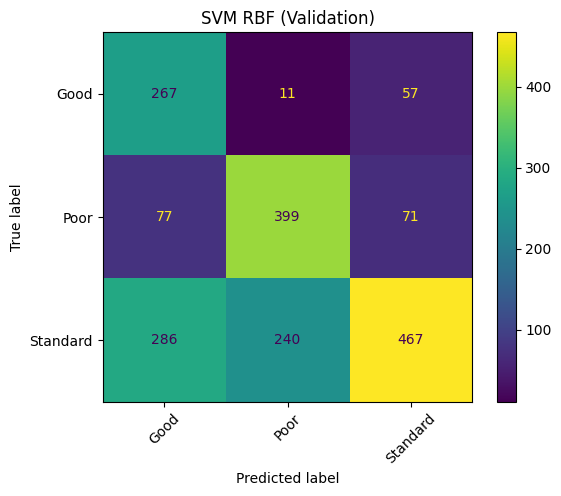


=== Test ===
Macro-F1: 0.6084
Balanced Acc: 0.6652
Macro ROC-AUC (OvR): 0.7943

Classification Report:
               precision    recall  f1-score   support

        Good     0.4376    0.7619    0.5559       336
        Poor     0.6059    0.7477    0.6694       547
    Standard     0.7837    0.4859    0.5999       992

    accuracy                         0.6117      1875
   macro avg     0.6091    0.6652    0.6084      1875
weighted avg     0.6698    0.6117    0.6123      1875



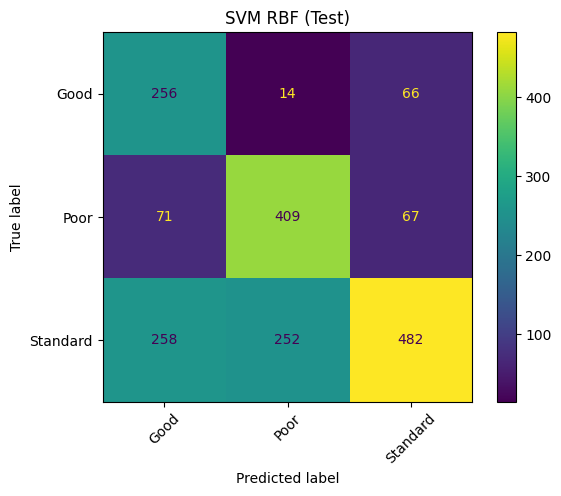

In [30]:
# <Student to fill this section>
# Validate
val_pred = best_svc.predict(X_val_safe)
val_proba = best_svc.predict_proba(X_val_safe)
print("\n=== Validation ===")
print("Macro-F1:", f"{f1_score(y_val_enc, val_pred, average='macro'):.4f}")
print("Balanced Acc:", f"{balanced_accuracy_score(y_val_enc, val_pred):.4f}")
print("Macro ROC-AUC (OvR):", f"{roc_auc_score(y_val_enc, val_proba, multi_class='ovr', average='macro'):.4f}")
print("\nClassification Report:\n", classification_report(y_val_enc, val_pred, target_names=class_names, digits=4))
ConfusionMatrixDisplay(confusion_matrix(y_val_enc, val_pred), display_labels=class_names).plot(xticks_rotation=45)
plt.title("SVM RBF (Validation)"); plt.show()

# Test
test_pred = best_svc.predict(X_test_safe)
test_proba = best_svc.predict_proba(X_test_safe)
print("\n=== Test ===")
print("Macro-F1:", f"{f1_score(y_test_enc, test_pred, average='macro'):.4f}")
print("Balanced Acc:", f"{balanced_accuracy_score(y_test_enc, test_pred):.4f}")
print("Macro ROC-AUC (OvR):", f"{roc_auc_score(y_test_enc, test_proba, multi_class='ovr', average='macro'):.4f}")
print("\nClassification Report:\n", classification_report(y_test_enc, test_pred, target_names=class_names, digits=4))
ConfusionMatrixDisplay(confusion_matrix(y_test_enc, test_pred), display_labels=class_names).plot(xticks_rotation=45)
plt.title("SVM RBF (Test)"); plt.show()

In [31]:
# <Student to fill this section>
model_performance_explanations = """
SAFE: Val macro-F1 0.6048, bAcc 0.6632, ROC-AUC 0.7830; Test macro-F1 0.6162, bAcc 0.6720, ROC-AUC 0.7945. Good recall is highest (≈0.78 Val / 0.76 Test), but Standard recall drops (~0.49 Val). LEAK: macro-F1 ≈ 0.606 (no real gain). Gender does not improve metrics.
"""

In [32]:
# DO NOT MODIFY THE CODE IN THIS CELL
print_tile(size="h3", key='model_performance_explanations', value=model_performance_explanations)

### G.5 Business Impact from Current Model Performance


In [ ]:
# <Student to fill this section>

In [33]:
# <Student to fill this section>
business_impacts_explanations = """
SVM-SAFE is useful for marketing and pre-approval where Good recall is the priority. Lower macro-F1 and weaker calibration reduce suitability for strict risk policies. LEAK adds a sensitive attribute with no benefit and raises compliance risk, so it is not deployable."""

In [34]:
# DO NOT MODIFY THE CODE IN THIS CELL
print_tile(size="h3", key='business_impacts_explanations', value=business_impacts_explanations)

## H. Experiment Outcomes

In [35]:
# <Student to fill this section>
experiment_outcome = 'Hypothesis Partially Confirmed'

In [36]:
# DO NOT MODIFY THE CODE IN THIS CELL
print_tile(size="h2", key='experiment_outcomes_explanations', value=experiment_outcome)

In [37]:
# <Student to fill this section>
experiment_results_explanations = """
SVM-SAFE delivers the highest Good recall and competitive balanced accuracy (~0.67) but trails RF/HGB on macro-F1 and calibration. Next steps: use calibrated wrappers (e.g., CalibratedClassifierCV), tune class-wise thresholds for marketing use, and keep SVM as a specialized tool for Good recall scenarios. Maintain the SAFE feature policy and exclude gender."""

In [38]:
# DO NOT MODIFY THE CODE IN THIS CELL
print_tile(size="h2", key='experiment_results_explanations', value=experiment_results_explanations)